In [2]:
from vedo import Mesh, Box, Sphere, ConvexHull
import numpy as np
# import matplotlib as plt
import matplotlib.pyplot as plt
from normalize import get_eigenvectors, normalize_shape, get_center_of_mass
import os
import pandas as pd
from glob import glob
import concurrent.futures
import time


In [3]:
boxMesh = normalize_shape(Box(width=1,height=1,length=1).c("Black").wireframe(True))
sphereMesh = normalize_shape(Sphere(r=1, res=24, quads=False, c='red', alpha=1.0))
train = normalize_shape(Mesh("../shapes/Train/D01014.obj"))
head = normalize_shape(Mesh("../shapes/HumanHead/D00131.obj"))
insect = normalize_shape(Mesh("../shapes/Insect/D00117.obj"))

door1 = normalize_shape(Mesh("../shapes/Door/D01177.obj"))
door2 = normalize_shape(Mesh("../shapes/Door/D01141.obj"))
humanoid = normalize_shape(Mesh("../shapes/Humanoid/m155.obj"))
bycicle = normalize_shape(Mesh("../shapes/Bicycle/D00567.obj"))



Box: {'area': 5.999999999999999, 'volume': 0.9999999999999998, 'rectangularity': 0.9999999999999998, 'compactness': 1.9098593171027443, 'convexity': 0.9999999999999999, 'eccentricity': 1.0, 'diameter': 1.7320508, 'diameterPts': [array([ 0.5, -0.5, -0.5], dtype=float32), array([-0.5,  0.5,  0.5], dtype=float32)], 'distributions': {'A3': array([0.00827653, 0.02531646, 0.04089581, 0.04673807, 0.05550146,
       0.06037001, 0.07643622, 0.0744888 , 0.07010711, 0.06621227,
       0.07497566, 0.06037001, 0.05306719, 0.05209348, 0.04333009,
       0.04479065, 0.03505355, 0.02288218, 0.02434275, 0.01655307,
       0.01363194, 0.00925024, 0.00827653, 0.00389484, 0.00340798,
       0.00292113, 0.00243427, 0.00194742, 0.00194742, 0.00048685]), 'D1': array([0.03602726, 0.04284323, 0.03894839, 0.04673807, 0.04284323,
       0.03505355, 0.04284323, 0.05452775, 0.03505355, 0.05063291,
       0.05063291, 0.05452775, 0.04673807, 0.04673807, 0.05452775,
       0.05063291, 0.04479065, 0.05452775, 0.035053

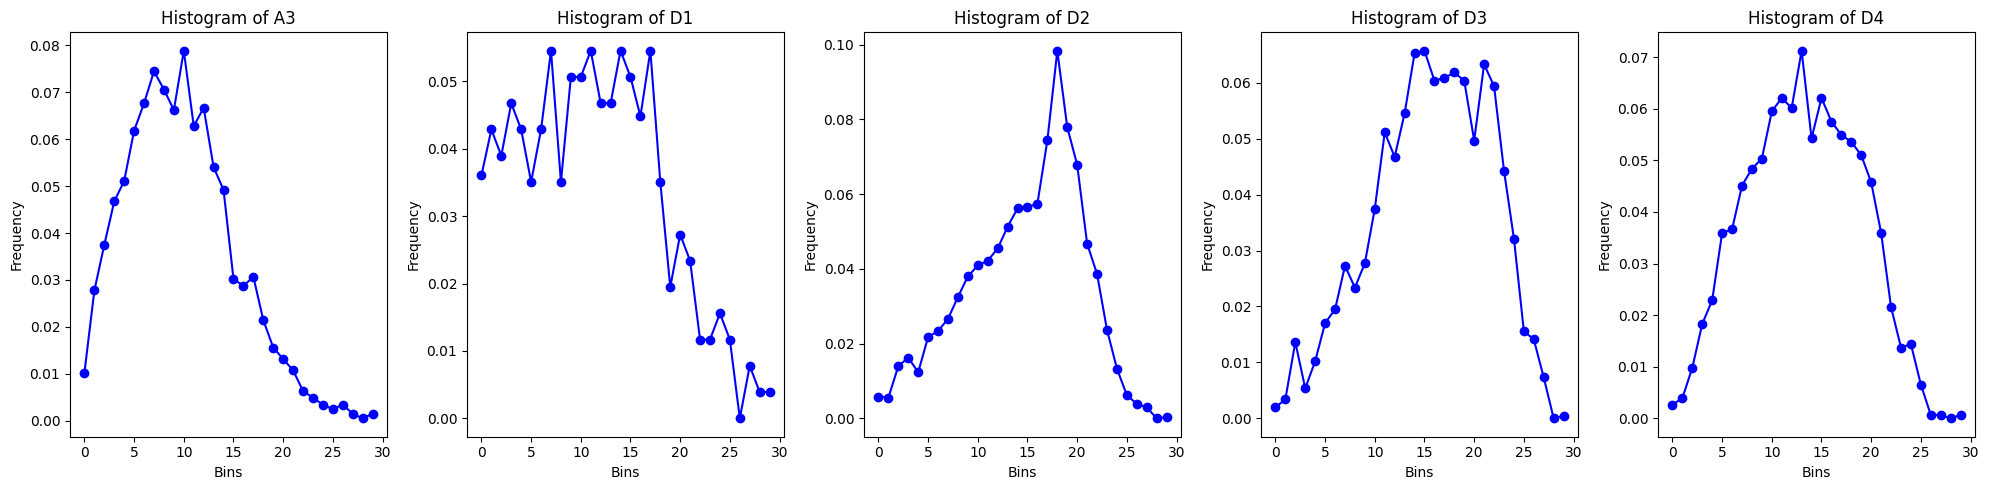

In [5]:
def extract_features(mesh:Mesh):
    cvx = ConvexHull(mesh.vertices)
    diameterRet = get_diameter(mesh,cvx)
    mesh.fill_holes()
    mesh.triangulate()
    ret = {
        "area":mesh.area(),
        "volume":mesh.volume(),
        "rectangularity":get_rectangularity(mesh),
        "compactness":get_compactness(mesh),
        "convexity": get_convexity(mesh,cvx),
        "eccentricity":get_eccentricity(mesh),
        "diameter":diameterRet[0],
        "diameterPts":diameterRet[1],
        "distributions":get_distributions(mesh)
    }
    return ret

# 2 methods to avoid NaN values
def safe_norm(v):
    norm = np.linalg.norm(v)
    if np.isnan(norm) or np.isinf(norm):
        return 0.0  
    return norm

def safe_cross(v1, v2):
    cross_prod = np.cross(v1, v2)
    if np.isnan(cross_prod).any() or np.isinf(cross_prod).any():
        return np.zeros_like(cross_prod) 
    return cross_prod

# # subsampling vertices using smart subsampling
# def subsample_vertices(vertices, num_samples = 1000, num_vertices=3):
#     N = len(vertices)  
#     k = int(np.cbrt(num_samples)) 

#     sampled_groups = []

#     for i in range(k):
#         vi = np.random.randint(0, N)  
#         for j in range(k):
#             vj = np.random.randint(0, N)
#             if vj == vi:
#                 continue  
#             if num_vertices == 2:
#                 sampled_groups.append((vertices[vi], vertices[vj]))
#                 continue

#             for l in range(k):
#                 vl = np.random.randint(0, N)
#                 if vl == vi or vl == vj:
#                     continue  
#                 if num_vertices == 3:
#                     sampled_groups.append((vertices[vi], vertices[vj], vertices[vl]))
#                     continue
#                 for m in range(k):
#                     vm = np.random.randint(0, N)
#                     if vm == vi or vm == vj or vm == vl:
#                         continue  
#                     if num_vertices == 4:
#                         sampled_groups.append((vertices[vi], vertices[vj], vertices[vl], vertices[vm]))

#     return sampled_groups


def subsample_vertices(vertices, num_samples=1000, num_vertices=3):
    N = len(vertices)  
    k = min(num_samples, N // num_vertices)

    sampled_indices = np.random.choice(N, size=(k, num_vertices), replace=False)

    sampled_groups = vertices[sampled_indices]

    return sampled_groups


def get_surface_area(mesh:Mesh):
    #area = sqrt(fabs(s * (s - a) * (s - b) * (s - c)));
    return mesh.area()

def get_rectangularity(mesh:Mesh):
    #How close is the shape (post normalisation to its oriented bounding box)
    # (shape volume divided by OBB volume)
    bbox = mesh.bounds()
    Dx = np.abs(bbox[0] - bbox[1])  
    Dy = np.abs(bbox[2] - bbox[3])  
    Dz = np.abs(bbox[4] - bbox[5])  
    obbVol = Dx*Dy*Dz
    rectangularity = mesh.volume()/obbVol
    return rectangularity

def get_compactness(mesh:Mesh):
    #How close is the shape to a sphere
    return mesh.area()**3/(36*np.pi*(mesh.volume()**2))

def get_convexity(mesh:Mesh,cvx:ConvexHull):
    #(shape volume divided by convex hull volume)
    convexity = mesh.volume()/cvx.volume()
    return convexity

def get_diameter(mesh:Mesh,cvx:ConvexHull,k=500):
    maxD = 0
    maxP = [None,None]
    if(len(cvx.vertices)<k):
        subs=cvx.vertices
    else:
        subs = cvx.vertices[np.random.choice(cvx.vertices.shape[0], k, replace=False)]
    for v1 in subs:
        for v2 in cvx.vertices:
            d = np.linalg.norm(v1-v2)
            if d>maxD:
                maxD=d
                maxP = [v1,v2]
    return maxD,maxP        
        
def get_eccentricity(mesh:Mesh):
    #ratio of largest to smallest eigenvalues of covariance matrix
    _,eigval = get_eigenvectors(mesh)
    mineig = min(eigval)
    maxeig = max(eigval)
    return np.abs(maxeig)/np.abs(mineig)

def get_angle_between_vectors(v1, v2):
    #angle between two vectors 
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.arccos(np.clip(cos_angle, -1.0, 1.0))  

def get_hist(desc_vals, bins=10, normalize=True):
    hist, bin_edges = np.histogram(desc_vals, bins=bins, density = False) 
    if normalize:
        hist = hist / np.sum(hist) 
    
    # bin_edges = (bin_edges - np.min(bin_edges)) / (np.max(bin_edges) - np.min(bin_edges))

    return hist
# , bin_edges[:-1] 

def get_distributions(mesh:Mesh, show=True):
    num_samples = 100000
    bins = 30

    A3_vals = calc_A3(mesh, num_samples)
    D1_vals = calc_D1(mesh, num_samples)
    D2_vals = calc_D2(mesh, num_samples)
    D3_vals = calc_D3(mesh, num_samples) 
    D4_vals = calc_D4(mesh, num_samples)

    A3_hist = get_hist(A3_vals, bins)
    D1_hist = get_hist(D1_vals, bins)
    D2_hist = get_hist(D2_vals, bins)   
    D3_hist = get_hist(D3_vals, bins)
    D4_hist = get_hist(D4_vals, bins)

    distributions = {
        "A3":A3_hist,
        "D1":D1_hist,
        "D2":D2_hist, 
        "D3":D3_hist,
        "D4":D4_hist,

    }
    return distributions

def plot_hist(distributions):
    descriptor_names = distributions.keys()  #names
    
    #all histograms here
    fig, axs = plt.subplots(1, len(descriptor_names), figsize=(20, 5))

    # Plot each histogram
    for i, name in enumerate(descriptor_names):
        # hist, bin_centers = distributions[name]
        data = distributions[name]
        #axs[i].bar(range(len(distributions[name])), distributions[name])
        axs[i].plot(range(len(data)), data, marker='o', linestyle='-', color='b')  # Use line chart with markers
        axs[i].set_title(f"Histogram of {name}")
        axs[i].set_xlabel("Bins")
        axs[i].set_ylabel("Frequency")
        # axs[i].set_ylim([0, 1])  
        # axs[i].set_xlim([0, 1])
    
    plt.tight_layout()
    plt.show()

#Calculate distance between the center and a random subset, returns list of euclidian distances
# for D1 max num samples = nr of vertices
def calc_D1(mesh: Mesh, num_samples = 500):

    actual_num_vertices = mesh.vertices.shape[0]
    center = get_center_of_mass(mesh)
    nr_samples = min(num_samples, actual_num_vertices)
    subsample = mesh.vertices[np.random.choice(mesh.vertices.shape[0], nr_samples, replace=False), :]

    ret = []
    # for pt in subs:
    for pt in subsample:
        # ret.append(np.linalg.norm(pt - center))
        ret.append(safe_norm(pt - center))
    return ret

# max num samples  = (nr of vertices)^3
def calc_A3(mesh: Mesh, num_samples = 500):
    # A3 for x(num_samples) number of times for each shape 
    angles = []
    vertices = mesh.vertices
    sampled_triples = subsample_vertices(vertices, num_samples, num_vertices=3) 
    # for _ in range(num_samples):
    #     v1, v2, v3 = vertices[np.random.choice(len(vertices), 3, replace=False)]
    for triple in sampled_triples:
        v1, v2, v3 = triple
        vec1 = v2 - v1
        vec2 = v3 - v1
        # angle = get_angle_between_vectors(vec1, vec2)
        # angles.append(angle)
        if safe_norm(vec1) > 0 and safe_norm(vec2) > 0:
            angle = get_angle_between_vectors(vec1, vec2)
            if not np.isnan(angle) and not np.isinf(angle):
                angles.append(angle)
    return np.array(angles)

# max num samples  = (nr of vertices) ^ 2
def calc_D2(mesh: Mesh, num_samples=500):
    # D2 for x number of times, return concatenated val
    distances = []
    vertices = mesh.vertices
    sampled_duples = subsample_vertices(vertices, num_samples, num_vertices = 2)
    # for _ in range(num_samples):
    #     v1, v2 = vertices[np.random.choice(len(vertices), 2, replace=False)]
    for duple in sampled_duples:
        v1, v2 = duple
        # distance = np.linalg.norm(v1 - v2)
        # distances.append(distance)
        distance = safe_norm(v1 - v2)
        if distance > 0 and not np.isnan(distance) and not np.isinf(distance):
            distances.append(distance)
    return np.array(distances)

# max num samples  = (nr of vertices)^3
def calc_D3(mesh: Mesh, num_samples = 500):
    areas = []
    vertices = mesh.vertices
    sampled_triples = subsample_vertices(vertices, num_samples, num_vertices=3) 
    # for _ in range(num_samples):
    #     v1, v2, v3 = vertices[np.random.choice(len(vertices), 3, replace=False)]
    for triple in sampled_triples:
        v1, v2, v3 = triple
        area = 0.5 * np.linalg.norm(np.cross(v2 - v1, v3 - v1))
        if area > 0 and not np.isnan(area) and not np.isinf(area):
           areas.append(np.sqrt(area))
    return np.array(areas)

# max num samples  = (nr of vertices)^4
def calc_D4(mesh: Mesh, num_samples = 500):
    volumes = []
    vertices = mesh.vertices
    sampled_quadruples = subsample_vertices(vertices, num_samples, num_vertices = 4)
    # for _ in range(num_samples):
    #     v1, v2, v3, v4 = vertices[np.random.choice(len(vertices), 4, replace=False)]
    for q in sampled_quadruples:
        v1, v2, v3, v4 = q
        # volume of tetrahedron
        volume = np.abs(np.dot((v4 - v1), np.cross(v2 - v1, v3 - v1))) / 6
        if volume > 0 and not np.isnan(volume) and not np.isinf(volume):
          volumes.append(np.cbrt(volume))
    return np.array(volumes)

box_features = extract_features(boxMesh)

print("Box:",extract_features(boxMesh))
print("Sphere:",extract_features(sphereMesh))
print("Train:",extract_features(train))
print("Head:",extract_features(head))
print("Insect:",extract_features(insect))

plot_hist(box_features['distributions'])

    

Comparing 2 meshes from the same class and one from a different one: can see that the Histograms are similar for all features for the first 2 meshes and different for the last one.

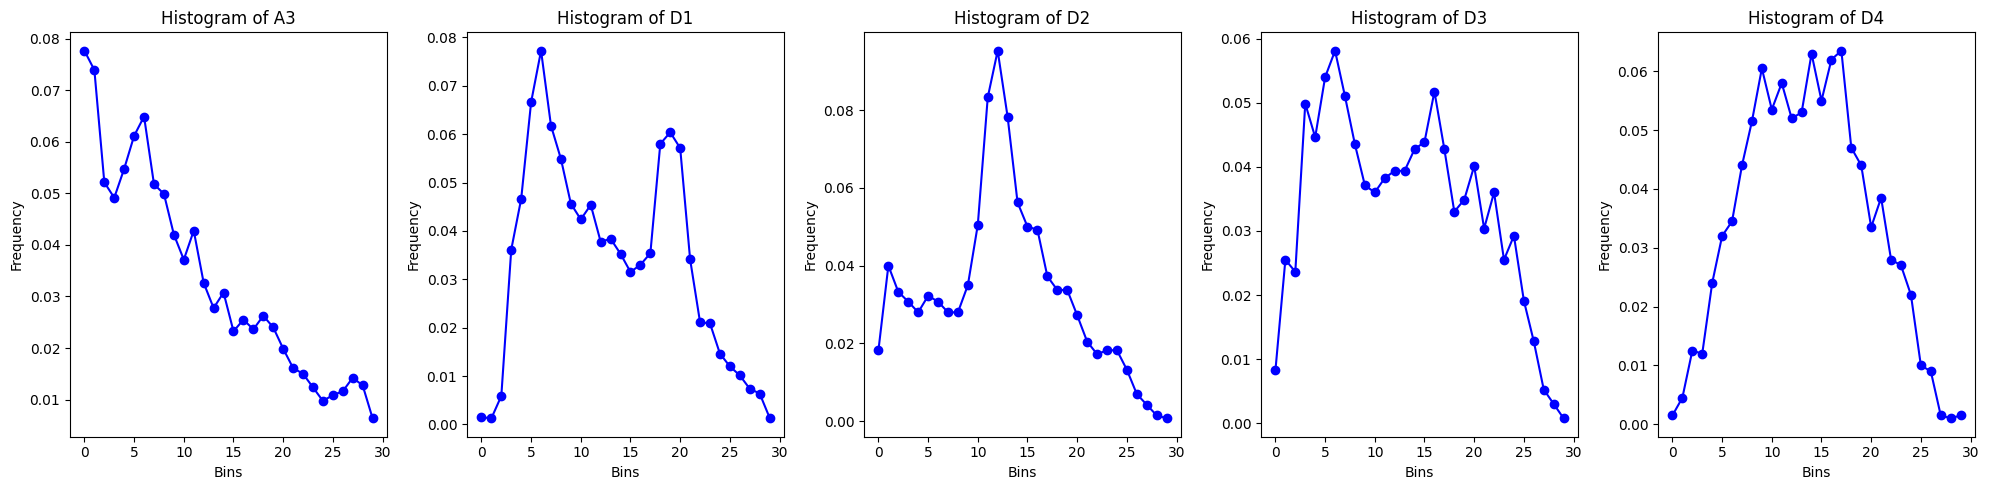

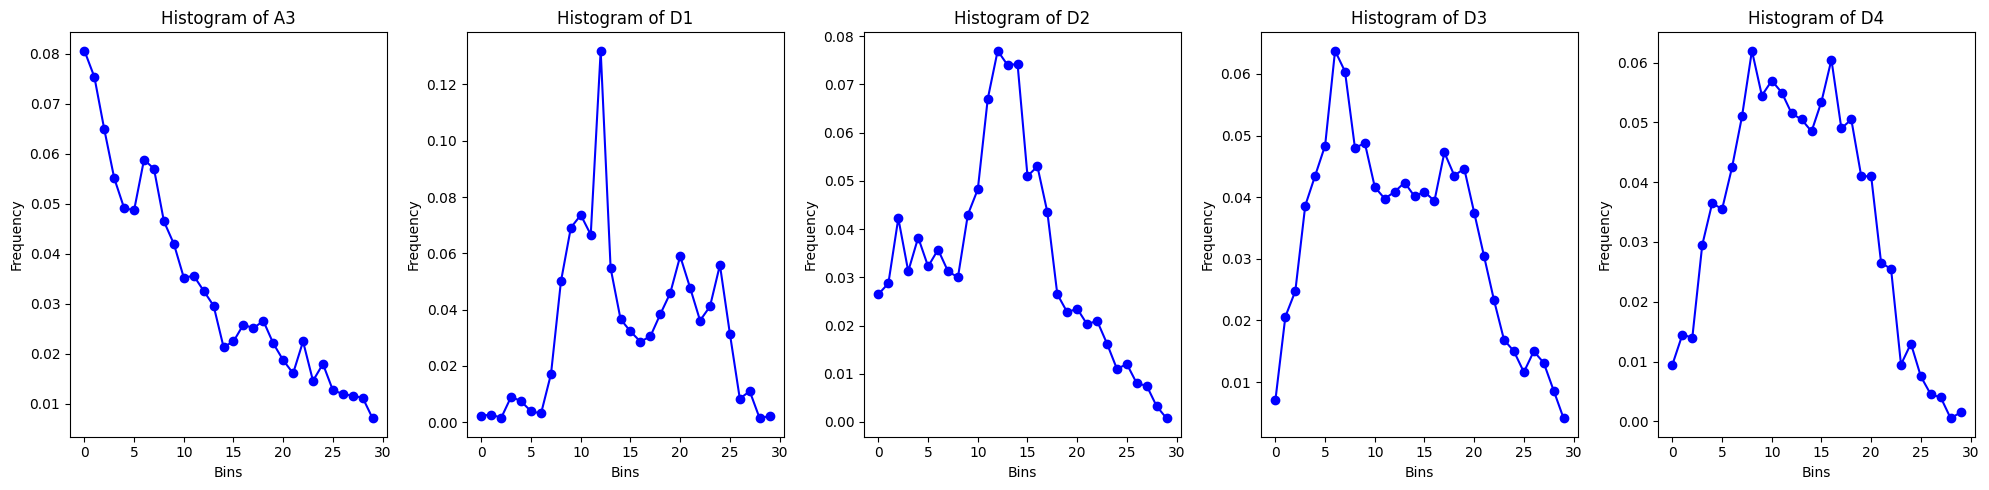

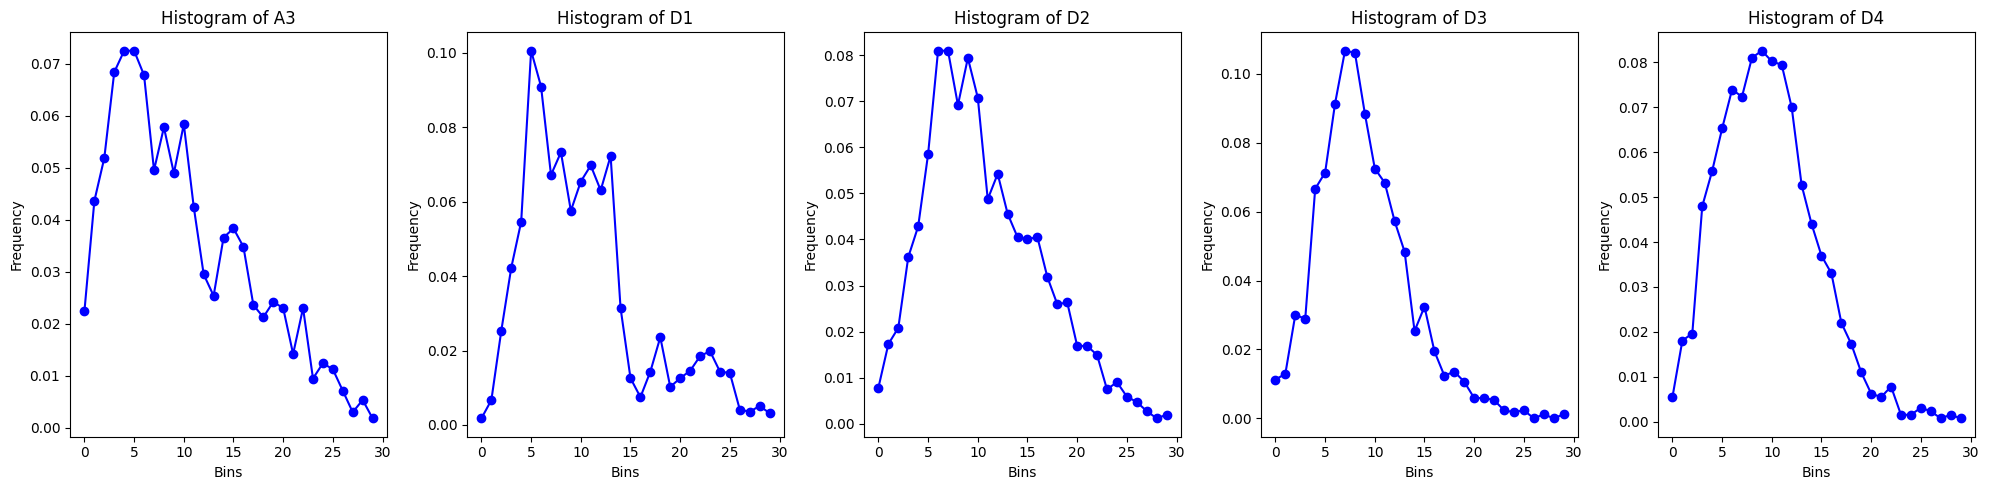

In [26]:
door1_features = extract_features(door1)
door2_features = extract_features(door2)
insect_features = extract_features(insect)
humanoid_features = extract_features(humanoid)
bycicle_features = extract_features(bycicle)

plot_hist(door1_features['distributions'])
plot_hist(door2_features['distributions'])
plot_hist(insect_features['distributions'])

Difficult Calculations
Area - Positive vs Negative (RIght hand rule, counterclockwise orientation = positive, thumb away from screen)
    Solution 1) Ignore sign -> Problem Concave Shapes have "negative" areas -> Areas are overstimated
    Same applies for volume
    Solution 2) Incooperate Sign -> Allow negative areas, concavities are incooperated. Problem: consistent orientation along boundary
    FOr VOlumes check orientation of triangles. -> Get Consistently oriented triangles.

HOle Filling:
Every Edge is shared by two triangles. If an edge has a single edge -> it is a boundary. If you have a boundary loop -> fill. 


In [9]:
print(len(head.vertices))
chull = ConvexHull(head.vertices)
print(len(chull.vertices))

5161
1809


Saving features for each mesh in a csv file , so working with the entire dataset

In [36]:
# this is for the subset dataset

df_manifest = pd.read_csv("./subset_shape_manifest.csv")
df_manifest = df_manifest[df_manifest['ReturnCode'] == 0]

def extract_dataset_features_from_shapes(shape_directory="shapes", output_file="subset_mesh_features.csv", timeout=60):
    feature_data = []
    skipped = 0
    valid_meshes = set(df_manifest['Path'])

    print("Sample valid paths from manifest:", list(valid_meshes)[:5])   

    for class_name in os.listdir(shape_directory):
        class_path = os.path.join(shape_directory, class_name)
        
        if os.path.isdir(class_path):
            mesh_files = glob(os.path.join(class_path, '*.obj'))
            
            for mesh_file in mesh_files:
                relative_path = "../" + os.path.relpath(mesh_file, start='..')

                # DEBUG only
                print(f"Processing mesh: {relative_path}")
                
                # Skip meshes not in the manifest
                if relative_path not in valid_meshes:
                    print(f"Skipping mesh {relative_path}, not in manifest")
                    continue

                mesh = normalize_shape(Mesh(mesh_file))
                
                def process_mesh(mesh):
                    return extract_features(mesh)
                
                # Try to extract features with a timeout
                try:
                    with concurrent.futures.ThreadPoolExecutor() as executor:
                        future = executor.submit(process_mesh, mesh)
                        features = future.result(timeout=timeout)  # Set timeout here
                    
                    feature_row = {
                        "mesh_name": os.path.basename(mesh_file),  
                        "class": class_name,                        
                        "area": features["area"],
                        "volume": features["volume"],
                        "rectangularity": features["rectangularity"],
                        "compactness": features["compactness"],
                        "convexity": features["convexity"],
                        "eccentricity": features["eccentricity"],
                        "diameter": features["diameter"]
                    }
                    
                    # Add histograms
                    for dist_name, dist_values in features["distributions"].items():
                        for bin_idx, bin_value in enumerate(dist_values):
                            feature_row[f"{dist_name}_bin_{bin_idx}"] = bin_value
                    
                    feature_data.append(feature_row)
                    print('Feature row added for mesh: ' + os.path.basename(mesh_file))
                
                except concurrent.futures.TimeoutError:
                    # Skip mesh if it takes too long
                    print(f"Skipping mesh {os.path.basename(mesh_file)} due to timeout.")
                    skipped += 1
                except Exception as e:
                    print(f"Error processing mesh {os.path.basename(mesh_file)}: {str(e)}")

    feature_df = pd.DataFrame(feature_data)
    target_directory = os.getcwd()  

    output_path = os.path.join(target_directory, output_file)
    feature_df.to_csv(output_path, index=False)
    print(f"Feature extraction complete. Features saved to {output_path}.")
    print("Skipped meshes count: " + str(skipped))


extract_dataset_features_from_shapes(shape_directory="INFOMR-final-project/shapes", output_file="subset_mesh_features.csv")


Sample valid paths from manifest: ['../shapes/Cup/m502.obj', '../shapes/AquaticAnimal/m73.obj', '../shapes/City/m1654.obj', '../shapes/Chess/m1596.obj', '../shapes/Motorcycle/m1481.obj']
Processing mesh: ../shapes/Insect/D00309.obj
Skipping mesh ../shapes/Insect/D00309.obj, not in manifest
Processing mesh: ../shapes/Insect/D00136.obj
Skipping mesh ../shapes/Insect/D00136.obj, not in manifest
Processing mesh: ../shapes/Insect/D00081.obj
Skipping mesh ../shapes/Insect/D00081.obj, not in manifest
Processing mesh: ../shapes/Insect/D00732.obj
Skipping mesh ../shapes/Insect/D00732.obj, not in manifest
Processing mesh: ../shapes/Insect/D00109.obj
Skipping mesh ../shapes/Insect/D00109.obj, not in manifest
Processing mesh: ../shapes/Insect/D00294.obj
Skipping mesh ../shapes/Insect/D00294.obj, not in manifest
Processing mesh: ../shapes/Insect/D00082.obj
Skipping mesh ../shapes/Insect/D00082.obj, not in manifest
Processing mesh: ../shapes/Insect/D00333.obj
Skipping mesh ../shapes/Insect/D00333.ob

In [7]:
# this is only for a few meshes from each class just for plotting
def extract_dataset_features_from_shapes(shape_directory="shapes", output_file="all_mesh_features.csv", allowed_classes=None, max_meshes_per_class=20, timeout=60):
    feature_data = []
    skipped = 0

    allowed_classes = allowed_classes or os.listdir(shape_directory)

    for class_name in os.listdir(shape_directory):
        class_path = os.path.join(shape_directory, class_name)
        
        
        if allowed_classes and class_name not in allowed_classes:
            print(f"Skipping class {class_name} as it is not in the allowed classes list.")
            continue
        
        if os.path.isdir(class_path):
            mesh_files = glob(os.path.join(class_path, '*.obj'))

            if len(mesh_files) > max_meshes_per_class:
                mesh_files = mesh_files[:max_meshes_per_class]  

            for mesh_file in mesh_files:
                mesh = normalize_shape(Mesh(mesh_file))
                
                def process_mesh(mesh):
                    return extract_features(mesh)
                
                try:
                    with concurrent.futures.ThreadPoolExecutor() as executor:
                        future = executor.submit(process_mesh, mesh)
                        features = future.result(timeout=timeout)  
                    
                    feature_row = {
                        "mesh_name": os.path.basename(mesh_file),  
                        "class": class_name,                        
                        "area": features["area"],
                        "volume": features["volume"],
                        "rectangularity": features["rectangularity"],
                        "compactness": features["compactness"],
                        "convexity": features["convexity"],
                        "eccentricity": features["eccentricity"],
                        "diameter": features["diameter"]
                    }
                    
                    for dist_name, dist_values in features["distributions"].items():
                        for bin_idx, bin_value in enumerate(dist_values):
                            feature_row[f"{dist_name}_bin_{bin_idx}"] = bin_value
                    
                    feature_data.append(feature_row)
                    print('Feature row added for mesh: ' + os.path.basename(mesh_file))
                
                except concurrent.futures.TimeoutError:
                    # Skip if it takes too long
                    print(f"Skipping mesh {os.path.basename(mesh_file)} due to timeout.")
                    skipped += 1
                except Exception as e:
                    print(f"Error processing mesh {os.path.basename(mesh_file)}: {str(e)}")

    feature_df = pd.DataFrame(feature_data)
    target_directory = os.getcwd()  

    output_path = os.path.join(target_directory, output_file)
    feature_df.to_csv(output_path, index=False)
    print(f"Feature extraction complete. Features saved to {output_path}.")
    print("Skipped meshes count: " + str(skipped))

extract_dataset_features_from_shapes(
    shape_directory="../shapes", 
    output_file="all_mesh_features.csv", 
    allowed_classes=[ "Car" , "Drum" , "Fish", "Guitar" , "Rocket" , "Ship" , "Sword" , "Tool" , "Truck" , "Vase" , "Wheel"], 
    max_meshes_per_class=30
)

Skipping class Insect as it is not in the allowed classes list.
Skipping class Bookset as it is not in the allowed classes list.
Skipping class Tree as it is not in the allowed classes list.
Skipping class RectangleTable as it is not in the allowed classes list.
Feature row added for mesh: m720.obj
Feature row added for mesh: D00916.obj
Feature row added for mesh: D00484.obj
Feature row added for mesh: m697.obj
Feature row added for mesh: m696.obj
Feature row added for mesh: m709.obj
Feature row added for mesh: m721.obj
Feature row added for mesh: m694.obj
Feature row added for mesh: m695.obj
Feature row added for mesh: m691.obj
Feature row added for mesh: m690.obj
Feature row added for mesh: m719.obj
Feature row added for mesh: m692.obj
Feature row added for mesh: m687.obj
Feature row added for mesh: m693.obj
Feature row added for mesh: D00133.obj
Feature row added for mesh: D00906.obj
Feature row added for mesh: m718.obj
Feature row added for mesh: D00356.obj
Feature row added for me

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

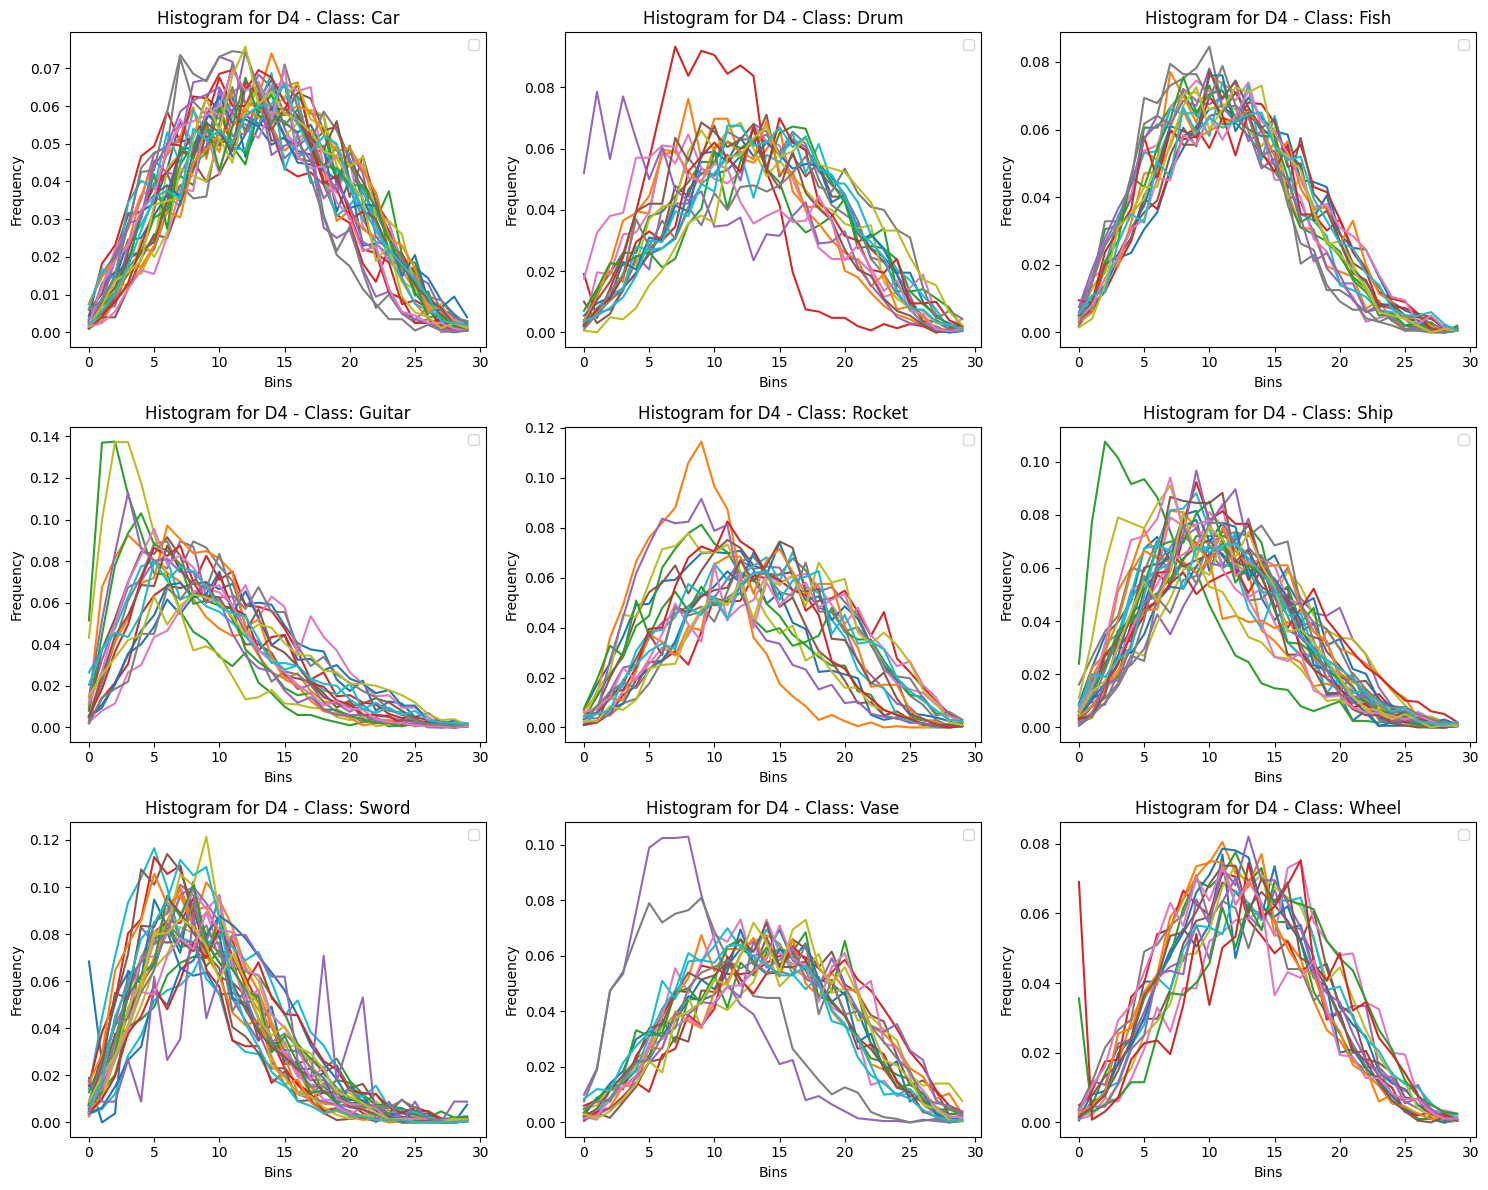

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

def load_features(file_path):
    return pd.read_csv(file_path)

# 3x3 figure with the histograms
def plot_histograms_for_classes(feature_df, descriptor_name, selected_classes):
    filtered_df = feature_df[feature_df['class'].isin(selected_classes)]
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))  
    
    axes = axes.flatten()

    for i, class_name in enumerate(selected_classes):
        class_df = filtered_df[filtered_df['class'] == class_name]
        ax = axes[i]  

        ax.set_title(f'Histogram for {descriptor_name} - Class: {class_name}')
        ax.set_xlabel('Bins')
        ax.set_ylabel('Frequency')

        for idx, row in class_df.iterrows():

            histogram_values = [row[f"{descriptor_name}_bin_{j}"] for j in range(30)]  
            ax.plot(range(30), histogram_values)

        ax.legend(loc='upper right') 
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    features_file = "all_mesh_features.csv"  
    feature_df = load_features(features_file)
    
    selected_classes = [ "Car", "Drum", "Fish", "Guitar", "Rocket", "Ship", "Sword", "Vase", "Wheel"]
    
    descriptor_name = "D4"

    plot_histograms_for_classes(feature_df, descriptor_name, selected_classes)
